## Experiment

This code corresponds to experiment (i.1) in the paper.

## Environment

The CartPole environment consists of a pole which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. The state space is represented by four values: cart position, cart velocity, pole angle, and the velocity of the tip of the pole. The action space consists of two actions: moving left or moving right. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

Source: [https://gym.openai.com/envs/CartPole-v1/](Open AI Gym). 

### Modifications to CartPole-v1

The environment is wrapped to contain the `noop` action, the `noop` action is required to learn a causal forward model as described in the paper. The failure angle has also been modified, the pole can now fall much further.

The kinematics integrator can also be changed with the `euler` option. A euler integrator will not change the position or angle immedately after taking an action, where as a non-euler integrator will (although the change is small when compared with the change in velocity).

### Action Space
The action is a `ndarray` with shape `(1,)` which can take values `{0, 1, 2}` indicating the direction
of the fixed force the cart is pushed with.

| Num | Action                 |
|-----|------------------------|
| 0   | Noop                   | 
| 1   | Push cart to the left  |
| 2   | Push cart to the right |

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it
### Observation Space
The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | -Inf                | Inf               |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

The cell below plots a bunch of example frames from the environment.

Install this repo as a dependency:

```
import sys
!{sys.executable} -m pip install -e ./reafference
```


In [1]:
# imports
import gym
import math
import time
import copy
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from IPython.display import clear_output

import reafference.jnu as J

from reafference.environment.cartpole import ground_truth, get_images, make_episode, make_dataset, plot # if error install local repo
from reafference.environment.cartpole import make

from reafference import environment

ANGLE_THRESHOLD = float('inf') # no angle threshold, episode will end when the cart moves out of bounds.
EULER = True
DEVICE = "cuda:0"

/home/ben/anaconda3/envs/reaff/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ben/anaconda3/envs/reaff/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


------------------ Total Effects ------------------


/home/ben/anaconda3/envs/reaff/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Canvas).__init__(scale=1).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/ben/anaconda3/envs/reaff/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=98), Output()), _dom…

<Figure size 720x288 with 0 Axes>

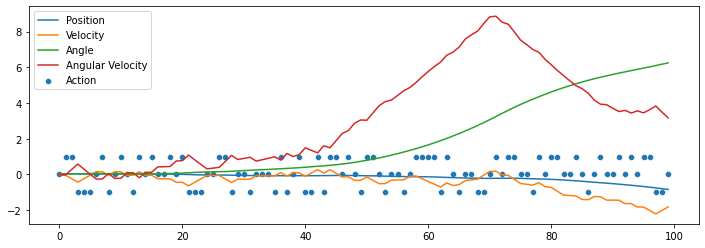

<Figure size 864x288 with 0 Axes>

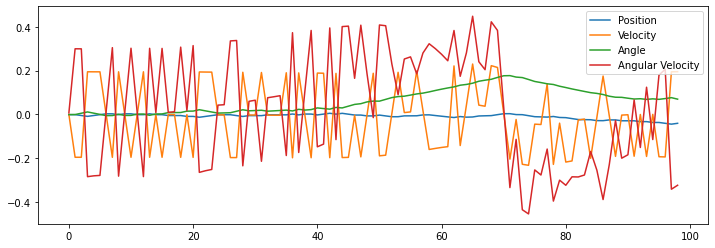

<Figure size 864x288 with 0 Axes>

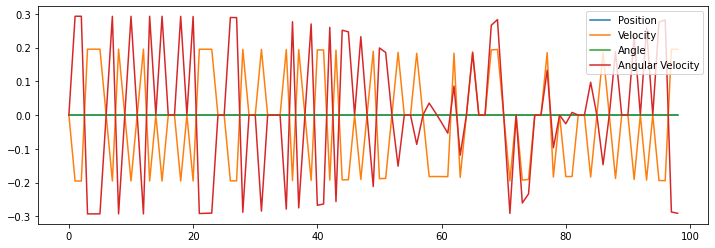

<Figure size 864x288 with 0 Axes>

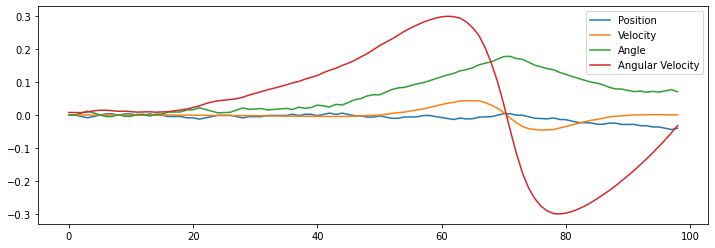

In [2]:
# Data Exploration
env = make(render=True, angle_threshold=ANGLE_THRESHOLD, euler=EULER)
state, action, info = make_episode(env, max_length=100)
imgs = info['img']

# -1 = right, 0 = noop, 1 = left
action = action.copy()
action[action == 2] = -1 

print("------------------ Total Effects ------------------")
diff = 1-(imgs[:-1] - imgs[1:])
show = np.concatenate([imgs[:-1], diff], axis=-1)
J.images(show, on_interact=action)

total_effect, re_effect, ex_effect = ground_truth(env, state)

fig = plt.figure(figsize=(10,4))
fig.suptitle("State")
plot(state, action=action)

fig = plt.figure(figsize=(12,4))
fig.suptitle("Total Effect")
plot(total_effect)

fig = plt.figure(figsize=(12,4))
fig.suptitle("Reafferent Effect")
plot(re_effect)

fig = plt.figure(figsize=(12,4))
fig.suptitle("Exafferent Effect")
plot(ex_effect)

plt.legend()

#s = 10
#n = 10
#fade = imgs[:n*5:5] * 1-np.linspace(0,1,n).reshape((n,1,1,1))
#J.images(fade)
#J.image(fade.sum(0))

In [5]:
# make a dataset with a random policy
env = make(render=False, angle_threshold=ANGLE_THRESHOLD, euler=EULER)
dataset = make_dataset(env, num_episodes=1000, max_episode_length=100, device=DEVICE)

In [6]:
# simple MLP neural network to estimate effects
class CartPoleNet(torch.nn.Module):
    
    def __init__(self, input_shape=(4,), action_shape=(3,), hidden_shape=(256,)):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(input_shape[0] + action_shape[0], hidden_shape[0]), 
            nn.Tanh(),
            nn.Linear(hidden_shape[0], hidden_shape[0]),
            nn.Tanh(),
            nn.Linear(hidden_shape[0], hidden_shape[0]),
            nn.Tanh(),
            nn.Linear(hidden_shape[0], input_shape[0]))
            
    def forward(self, x, a):
        z = torch.cat([x,a], dim=-1)
        return self.l1(z)

state_shape = env.observation_space.shape
action_shape = (env.action_space.n,)
latent_shape = (512,)
epochs = 50

model = CartPoleNet(state_shape, action_shape, latent_shape).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()

import torchinfo
torchinfo.summary(model, input_data=(torch.zeros(2, *state_shape), torch.zeros(2, *action_shape)))

#model.load_state_dict(torch.load("./CartPoleNoop-v0.model.pt"))



Layer (type:depth-idx)                   Output Shape              Param #
CartPoleNet                              [2, 4]                    --
├─Sequential: 1-1                        [2, 4]                    --
│    └─Linear: 2-1                       [2, 512]                  4,096
│    └─Tanh: 2-2                         [2, 512]                  --
│    └─Linear: 2-3                       [2, 512]                  262,656
│    └─Tanh: 2-4                         [2, 512]                  --
│    └─Linear: 2-5                       [2, 512]                  262,656
│    └─Tanh: 2-6                         [2, 512]                  --
│    └─Linear: 2-7                       [2, 4]                    2,052
Total params: 531,460
Trainable params: 531,460
Non-trainable params: 0
Total mult-adds (M): 1.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.13
Estimated Total Size (MB): 2.15

In [7]:
loader = DataLoader(dataset, batch_size=1028, shuffle=True, drop_last=False)
    
# Train
epoch_iter = tqdm(range(epochs))

for e in epoch_iter:
    
    # make a dataset with a random policy

    #dataset = make_dataset(env, num_episodes=100, device=DEVICE)
    #
    avg_loss = []
    for x1, x2, a in loader:
        optim.zero_grad()
        
        # prediction of the total effect of each action
        pred_total_effect = model(x1, a)        
        # prediction of the exafferent effect - when all actions are noop  
        noop = torch.zeros_like(a)
        noop[:,0] = 1. 
        pred_exafferent_effect = model(x1, noop)
        
        # prediction of the reafferent effect (total - exafferent)
        # this will be 0 for any a == 0 in the batch
        pred_reafferent_effect = pred_total_effect - pred_exafferent_effect.detach()
        #pred_reafferent_effect[a[:,0] == 1] = 0. # detach gradients where reafferent effect should be 0 (?)
    
        pred_effect = pred_exafferent_effect + pred_reafferent_effect # combined effect
        total_effect = x2 - x1 # ground truth total effect
        
        loss = criterion(pred_effect, total_effect)
        loss.backward()
        avg_loss.append(loss.detach())
        optim.step()
    
    avg_loss = torch.stack(avg_loss).cpu().numpy().mean()
    epoch_iter.set_description(f"Loss: {avg_loss : .5f}")
        

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#torch.save(model.state_dict(), "./CartPoleNoop-v0.model.pt")

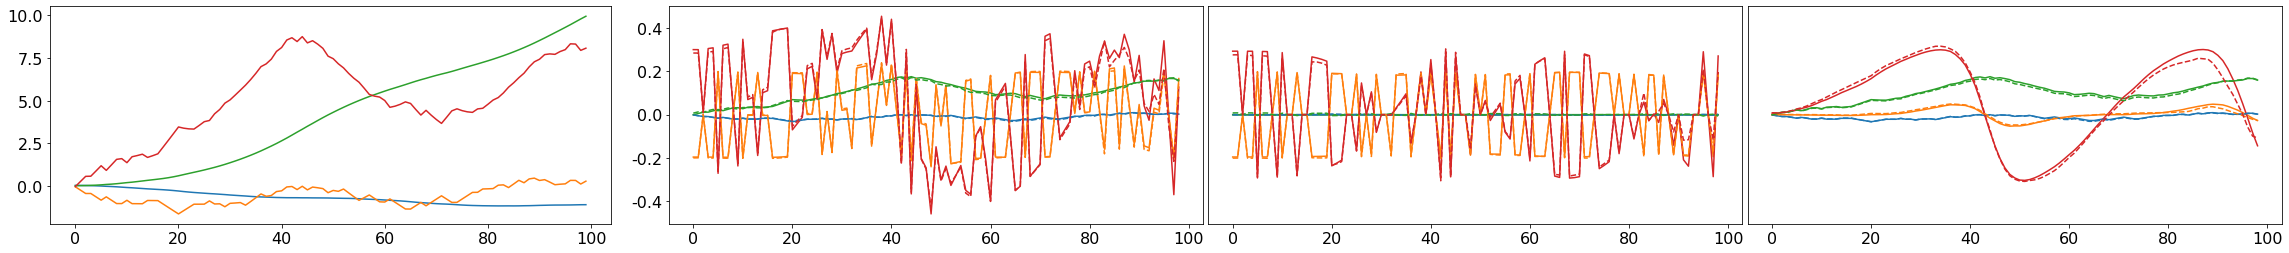

In [9]:
from matplotlib.ticker import StrMethodFormatter
import torchvision

# Results
env = make(angle_threshold=ANGLE_THRESHOLD, render=True, euler=EULER)
dataset_test = make_dataset(env, num_episodes=1, max_episode_length=100, device=DEVICE)

env.reset()

x1, x2, a = zip(*dataset_test)
x1, x2, a = torch.stack(x1), torch.stack(x2), torch.stack(a)

imgs = get_images(env, state, action)

diff = 1-(imgs[:-1] - imgs[1:])
show = np.concatenate([imgs[:-1], diff], axis=-1)
#J.images(show, on_interact=action)

#torchvision.io.write_video("./images/cartpole.mp4", (torch.from_numpy(show).permute(0,2,3,1) * 255.).int(), fps=20)

with torch.no_grad():
    pred_total = model(x1, a).cpu().numpy()
    noop = torch.zeros_like(a)
    noop[:,0] = 1. 
    pred_ex = model(x1, noop).cpu().numpy()
    pred_re = pred_total - pred_ex

x = torch.cat([x1, x2[-1:]], dim=0).cpu().numpy()
gt_total, gt_re, gt_ex = ground_truth(env, x)


# PLOT TOGETHER

import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(40,4))
gs1 = fig.add_gridspec(nrows=1, ncols=1, hspace=1)
ax0 = fig.add_subplot(gs1[0,0])
gs2 = fig.add_gridspec(nrows=1, ncols=3, hspace=0, wspace=0.01)
ax1 = fig.add_subplot(gs2[0,0])
ax2 = fig.add_subplot(gs2[0,1], sharey=ax1)
ax3 = fig.add_subplot(gs2[0,2], sharey=ax1)
axes = fig.axes

gs1.update(right=0.32)
gs2.update(left=0.34)

plot(x, style="-", fig=fig, ax=axes[0])
axes[0].get_legend().remove()
axes[0].yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))


plot(gt_total, style="-", fig=fig, ax=axes[1])
axes[1].set_prop_cycle(None)
plot(pred_total, style="--", label_prefix="Predicted ", fig=fig, ax=axes[1])
axes[1].get_legend().remove()
axes[1].yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))

#axes[1].set_ylim(axes[0].get_ylim())

plot(gt_re, style="-", fig=fig, ax=axes[2])
axes[2].set_prop_cycle(None)
plot(pred_re, style="--", label_prefix="Predicted ", fig=fig, ax=axes[2])
axes[2].get_legend().remove()
axes[2].yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))

plot(gt_ex, style="-", fig=fig, ax=axes[3])
axes[3].set_prop_cycle(None)
plot(pred_ex, style="--", label_prefix="Predicted ", fig=fig, ax=axes[3])
axes[3].get_legend().remove()
axes[3].yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))

ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
ax3.tick_params(axis='y', which='both', left=False, labelleft=False)


In [ ]:
#plt.savefig('./media/cartpole-all.png', bbox_inches='tight')


In [ ]:


# PLOT SEPERATLY
figsize = (8,4)
font = {'size'   : 16}
import matplotlib
#matplotlib.rc('font', **font)

fig = plt.figure(figsize=figsize)
#axes[0].set_title("Observation")
plot(x, style="-", fig=fig)
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-observation.png', bbox_inches='tight')

fig = plt.figure(figsize=figsize)
#axes[1].set_title("Total Effect")
plot(gt_total, style="-", fig=fig)#, ax=axes[1])
plt.gca().set_prop_cycle(None)
plot(pred_total, style="--", label_prefix="Predicted ", fig=fig)#, ax=axes[1])
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-total_effect.png', bbox_inches='tight')

fig = plt.figure(figsize=figsize)
#axes[2].set_title("Reafferent Effect")
plot(gt_re, style="-", fig=fig)#, ax=axes[2])
plt.gca().set_prop_cycle(None)
plot(pred_re, style="--", label_prefix="Predicted ", fig=fig)#, ax=axes[2])
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-reafferent_effect.png', bbox_inches='tight')


fig = plt.figure(figsize=figsize)
#axes[3].set_title("Exafferent Effect")
plot(gt_ex, style="-", fig=fig)#, ax=axes[3])
plt.gca().set_prop_cycle(None)
plot(pred_ex, style="--", label_prefix="Predicted ", fig=fig)#, ax=axes[3])
#plt.gca().legend(bbox_to_anchor=(1.02,-0.2))
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-exafferent_effect.png', bbox_inches='tight')



In [ ]:
# error proportions
def RPD(x, y):
    return (x - y) / (np.abs(x).max(0) + np.abs(y).max(0))


def _plot(x, y):
    x, y = np.exp(x), np.exp(y)
    plot(np.abs(x - y) / x)
    

_plot(gt_total, pred_total)
_plot(gt_re, pred_re)
_plot(gt_ex, pred_ex)





In [ ]:
# just plot position and angle for semi-euler environment

def plot(state, style="-", label_prefix="", fig=None):
    ax = fig.gca()
    state = state[:,::2]
    X = np.arange(state.shape[0])
    ax1 = sb.lineplot(x=X, y=state[:,0], label=f"{label_prefix}Position",          linestyle=style, ax=ax, color="tab:blue")
    ax2 = sb.lineplot(x=X, y=state[:,1], label=f"{label_prefix}Angle",          linestyle=style, ax=ax, color="tab:green")

fig = plt.figure(figsize=figsize)
#axes[0].set_title("Observation")
plot(x, style="-", fig=fig)
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-observation.png', bbox_inches='tight')

fig = plt.figure(figsize=figsize)
#axes[1].set_title("Total Effect")
plot(gt_total, style="-", fig=fig)#, ax=axes[1])
plt.gca().set_prop_cycle(None)
plot(pred_total, style="--", label_prefix="Predicted ", fig=fig)#, ax=axes[1])
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-total_effect.png', bbox_inches='tight')

fig = plt.figure(figsize=figsize)
#axes[2].set_title("Reafferent Effect")
plot(gt_re, style="-", fig=fig)#, ax=axes[2])
plt.gca().set_prop_cycle(None)
plot(pred_re, style="--", label_prefix="Predicted ", fig=fig)#, ax=axes[2])
plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-reafferent_effect.png', bbox_inches='tight')


fig = plt.figure(figsize=figsize)
#axes[3].set_title("Exafferent Effect")
plot(gt_ex, style="-", fig=fig)#, ax=axes[3])
plt.gca().set_prop_cycle(None)
plot(pred_ex, style="--", label_prefix="Predicted ", fig=fig)#, ax=axes[3])
plt.gca().legend(bbox_to_anchor=(1.02,-0.2))
#plt.gca().get_legend().remove()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.1f}'))
plt.savefig('./media/cartpole-exafferent_effect.png', bbox_inches='tight')





In [ ]:
# plot cumulative error
# error proportions

from reafference.environment.cartpole import plot 
pt = torch.from_numpy(pred_total)
gt = torch.from_numpy(gt_total)

pr = torch.from_numpy(pred_re)
gr = torch.from_numpy(gt_re)

pe = torch.from_numpy(pred_ex)
ge = torch.from_numpy(gt_ex)

criterion = torch.nn.MSELoss(reduction='none')

loss1 = torch.sqrt(criterion(pt, gt))
loss2 = torch.sqrt(criterion(pr, gr))
loss3 = torch.sqrt(criterion(pe, ge))
X = np.arange(loss1.shape[0])
plot(loss1)

plot(loss1 / gt)



fig = plt.figure() 
plot(gt)
plot(pt)